In [1]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from trim_transformer.transformer_layers import TrimTransformerEncoderLayer, \
                                                TrimTransformerEncoder

print("Device:", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

torch.manual_seed(42)
np.random.seed(42)


Device: cuda


In [2]:
# Define model parameters
EMBED_DIM = 512
NUM_HEADS = 8
NUM_LAYERS = 6
BATCH_SIZE = 8
SEQ_LENGTH = 128

# Create the transformer model
layer = TrimTransformerEncoderLayer(d_model=EMBED_DIM, nhead=NUM_HEADS, batch_first=True)
model = TrimTransformerEncoder(layer, num_layers=NUM_LAYERS)

# Create sample input data
x = torch.randn(BATCH_SIZE, SEQ_LENGTH, EMBED_DIM)

# Standard forward pass
output = model(x)

# Forward pass with causal masking
causal_output = model(x, is_causal=True)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Causal output shape: {causal_output.shape}")

Input shape: torch.Size([8, 128, 512])
Output shape: torch.Size([8, 128, 512])
Causal output shape: torch.Size([8, 128, 512])


In typical applications, a complete pipeline includes
1. An encoder to shape the data for the transformer.
2. Positional encoding to break the permutation equivariance of the transformer.
2. A decoder to shape the output of the transformer as desired.

See trim_vs_softmax.ipynb for an example of a complete pipeline.

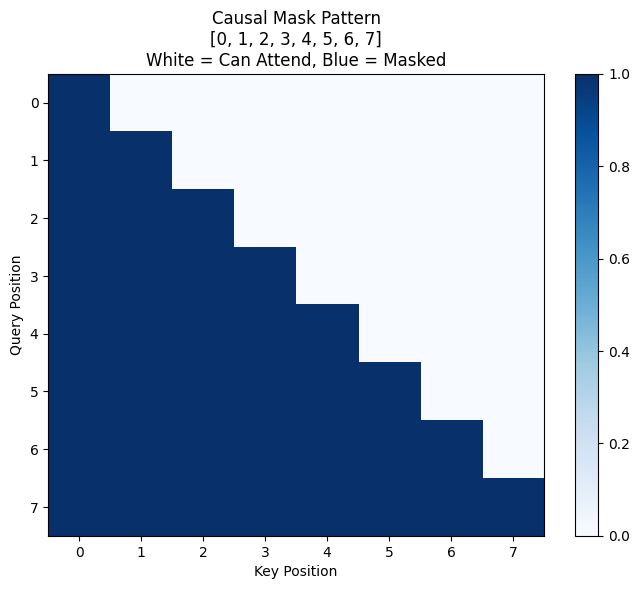

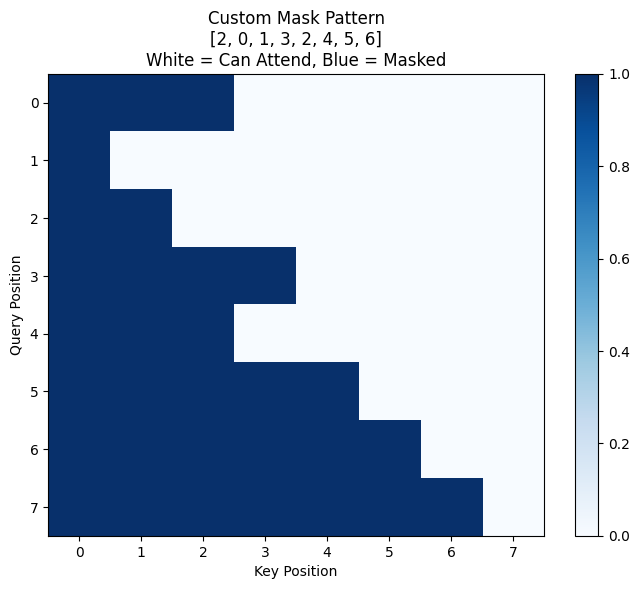

In [3]:
def mask_after_to_dense_mask(mask_after):
    n_tokens = mask_after.shape[0]
    col_indices = torch.arange(n_tokens)
    return (col_indices > mask_after.unsqueeze(1))

def visualize_mask_pattern(mask, title):
    """Convert integer mask to boolean attention matrix for visualization"""
    attention_matrix = mask_after_to_dense_mask(mask)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(~attention_matrix.numpy(), cmap='Blues', aspect='auto')
    plt.title(f"{title}\n{mask.tolist()}\nWhite = Can Attend, Blue = Masked")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.colorbar()
    plt.show()
    
    return attention_matrix

# Example 1: Causal mask (standard autoregressive pattern)
seq_len = 8
causal_mask = torch.arange(seq_len)
causal_attention = visualize_mask_pattern(causal_mask, "Causal Mask Pattern")

# Example 2: Custom mask - [2, 0, 1, 3, 2, 4, 5, 6]
custom_mask = torch.tensor([2, 0, 1, 3, 2, 4, 5, 6])
custom_attention = visualize_mask_pattern(custom_mask, "Custom Mask Pattern")


In [4]:
small_seq_len = 8
small_embed_dim = 64
small_x = torch.randn(1, small_seq_len, small_embed_dim)

small_layer = TrimTransformerEncoderLayer(d_model=small_embed_dim, nhead=4, batch_first=True)
small_model = TrimTransformerEncoder(small_layer, num_layers=2)

causal_output = small_model(small_x, mask=causal_mask)
custom_output = small_model(small_x, mask=custom_mask)
full_output = small_model(small_x, mask=None)

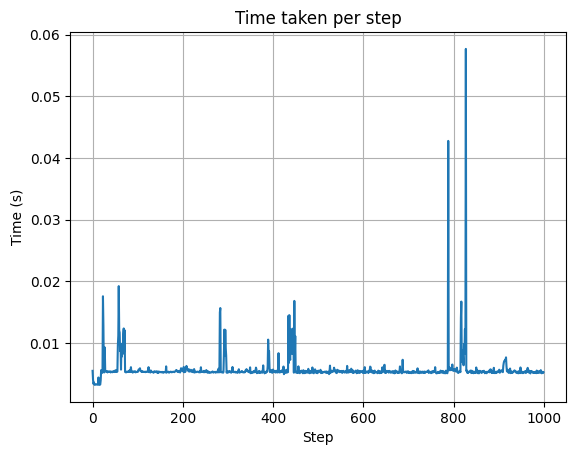

In [5]:
# generate tokens one step at a time
def generate(model, initial_tokens, num_new_tokens=5):
    """Autoregressive generation with caching"""
    model.eval()  # optional
    generated_sequence = []
    generation_times = []
    new_token = initial_tokens.clone()

    for _ in range(num_new_tokens):
        start_time = time.time()

        # Must set use_kv_cache=True and update_kv_cache=True to use key-value caching.
        # use_kv_cache=True means that the model will key-value cache that is already stored.
        # update_kv_cache=True means that the model will update the key-value cache with the
        # keys and values from the new token.
        output = model(new_token, is_causal=True, use_kv_cache=True, update_kv_cache=True)
        generated_sequence.append(output)

        end_time = time.time()
        generation_times.append(end_time - start_time)

    # Clear the key-value cache after generation. If you don't clear the cache, then if
    # use_kv_cache=True in the future, the model will continue to use the key-value cache
    # on future forward passes.
    model.clear_kv_cache()
    return generated_sequence, generation_times

# Create initial sequence
initial_seq = torch.randn(1, 10, 512)

gen_layer = TrimTransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
gen_model = TrimTransformerEncoder(gen_layer, num_layers=4)

generated_sequence, times = generate(
    gen_model, initial_seq, num_new_tokens=1000
)

plt.plot(times)
plt.title("Time taken per step")
plt.xlabel("Step")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()

# The time per step is approximately constant on average because the number of FLOPs
# is constant after the first step. In practice, hardware optimizations may make the
# time per step random.

In [6]:
import torch.nn as nn

custom_layer = TrimTransformerEncoderLayer(
    d_model=EMBED_DIM, 
    nhead=NUM_HEADS, 
    batch_first=True,
    q_weight_init=nn.init.normal_,
    k_weight_init=nn.init.normal_,
    v_weight_init=nn.init.normal_,
    norm_q=nn.RMSNorm(EMBED_DIM//NUM_HEADS),
    norm_k=nn.RMSNorm(EMBED_DIM//NUM_HEADS),
    norm_v=nn.RMSNorm(EMBED_DIM//NUM_HEADS),
    scale=1.0
)
custom_model = TrimTransformerEncoder(custom_layer, num_layers=NUM_LAYERS)
x = torch.randn(BATCH_SIZE, SEQ_LENGTH, EMBED_DIM)
output = custom_model(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([8, 128, 512])
Output shape: torch.Size([8, 128, 512])
